Homework 4: LLM evaluation
=====

The third homework zooms in on evaluating LLMs, specifically, on the following skills: using log probabilities of string under a trained LM to evaluate it, coming up with items to test particular aspets of LLMs, and comparing LLM measures to measures of human performance.

### Logistics

* submission deadline: July 13th th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW4.ipynb** containing your solutions of the homework. Make sure that your **plots** for the last exercise are either rendered in the notebook or submitted together with it in a zip file. 
* please solve and submit the homework **individually**! 
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.

In [ ]:
##### HONOUR CODE #####
# I received some help from Chi-Kuan Lai in debugging my codes.

## Exercise 1: Understanding grammatical capabilities of LLMs (10 points)

In this task, we look at [BLiMP](https://aclanthology.org/2020.tacl-1.25/), the benchmark of linguistic minimal pairs. This is a well-known benchmark for evaluating linguistic capabilities of language models. It consists of 67 individual datasets, each containing 1,000 minimal pairs -- that is, pairs of minimally different sentences that contrast in grammatical acceptability and isolate specific phenomenon in syntax, morphology, or semantics. The authors suggest to use the benchmark to evaluate LMs by observing whether they assign a higher probability to the acceptable sentence in each minimal pair.

> Your task is to evaluate an open-source model, [Pythia-160m](https://huggingface.co/EleutherAI/pythia-160m), on this benchmark by completing the code below. Based on your evaluation results, please answer the following questions.
> Please use the following test suites to answer them: anaphor_gender_agreement, determiner_noun_agreement_with_adjective_1, animate_subject_passive, complex_NP_island, npi_present_1, superlative_quantifiers_1, existential_there_object_raising, principle_A_case_1.
> 
> The entire benchmark can be found [here](https://huggingface.co/datasets/nyu-mll/blimp).
> 
> 1. Plot the accuracy of the model on the different grammatical phenomena, represented in different test suites.
> 2. Calculate the average accuracies and the confidence intervals in the different fields: syntax, morphology, syntax-semantics, semantics. Is the performance the same across the different fields? Which field is the most difficult one?
> 3. What is the easiest grammatical phenomenon, what is the most difficult gramamtical phenomenon (as captured by the single test suites) for the model?

## My answer
1. See the plots below
2. No, the performance are different across fields, with `syntax_semantics` being the most difficult one (it has the lowest accuracy as shown in the second plot).
3. The easiest: `npi_present_1`, the most difficult: `principle_A_case1`

In [13]:
# !pip install minicons
from datasets import load_dataset
import torch
from minicons import scorer 

In [14]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# print for sure
print(device)

cpu


In [19]:
# iterate over the test suites 

#### YOUR CODE HERE ####

test_suites = {
    'anaphor_gender_agreement': 'morphology',
    'determiner_noun_agreement_with_adjective_1': 'morphology',
    'animate_subject_passive': 'syntax',
    'complex_NP_island': 'syntax',
    'npi_present_1': 'semantics',
    'superlative_quantifiers_1': 'semantics',
    'existential_there_object_raising': 'syntax_semantics',
    'principle_A_case_1': 'syntax_semantics'
}

datasets = {}
for test_suite in test_suites:
    datasets[test_suite] = load_dataset("nyu-mll/blimp", test_suite)  # Load dataset for each test suite

# inspect the dataset
datasets['anaphor_gender_agreement']["train"][0]

{'sentence_good': "Katherine can't help herself.",
 'sentence_bad': "Katherine can't help himself.",
 'field': 'morphology',
 'linguistics_term': 'anaphor_agreement',
 'UID': 'anaphor_gender_agreement',
 'simple_LM_method': True,
 'one_prefix_method': True,
 'two_prefix_method': False,
 'lexically_identical': False,
 'pair_id': 0}

In [ ]:
# iterate over the single items of the test suite
# hint: you can use code similar to the one in sheet 7.1 

# set up the model as a minicons scorer 
lm_scorer = scorer.IncrementalLMScorer(
    ### YOUR CODE HERE ###
    "EleutherAI/pythia-160m", 
    device=device,
    force_download=True
)

# create some lists to store the results
### YOUR CODE HERE ###
def compute_accuracy(dataset, result):
    correct_predictions = 0
    total_predictions = 0

    for item in dataset["train"]:
        # get the sentence pair
        ### YOUR CODE HERE ###
        good_sent = item["sentence_good"]
        bad_sent = item["sentence_bad"]
        
        # Compare the sentences as suggested in the task description
        ### YOUR CODE HERE ###
        
        answer_scores = lm_scorer.conditional_score(
            [good_sent, bad_sent], 
            ["", ""] # reformat Qs into a list
        ) 
        
        if answer_scores[0] > answer_scores[1]:
            correct_predictions += 1
        total_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy, correct_predictions, total_predictions

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [33]:
# import pkgs for graphs
# !pip install statsmodels
import matplotlib.pyplot as plt 
from statsmodels.stats.proportion import proportion_confint
import numpy as np

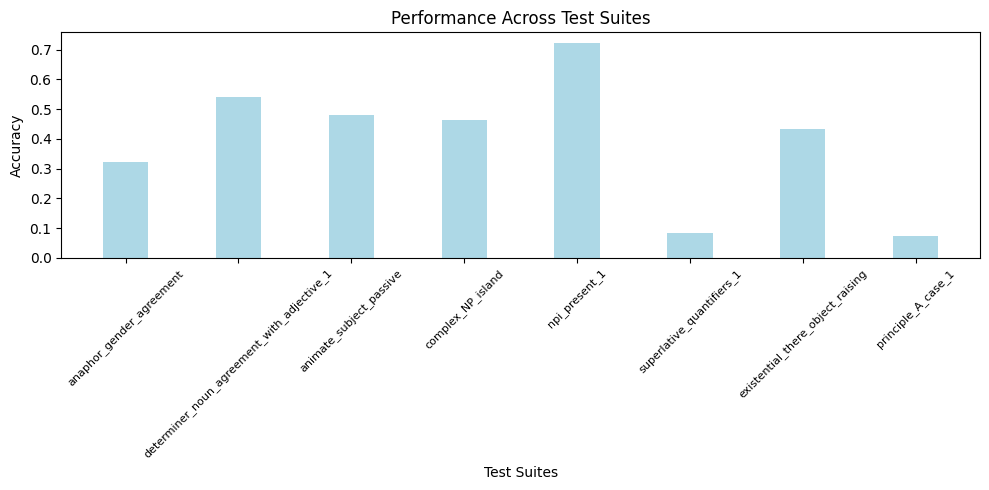

In [40]:
# calculate the performance by test suite
### YOUR CODE HERE ###

# Performance evaluation for each test suite
performance_data = {suite_name: compute_accuracy(data, scorer) for suite_name, data in datasets.items()}

# Performance aggregation by category
categories_list = ['morphology', 'syntax', 'semantics', 'syntax_semantics']
category_summary = {cat: {'correct_count': 0, 'total_count': 0} for cat in categories_list}

for suite_name, (accuracy, correct_count, total_count) in performance_data.items():
    suite_category = test_suites[suite_name]
    category_summary[suite_category]['correct_count'] += correct_count
    category_summary[suite_category]['total_count'] += total_count

# Calculate accuracy and confidence intervals for each category
accuracy_values = []
confidence_intervals_lower = []
confidence_intervals_upper = []

for cat in categories_list:
    correct_count = category_summary[cat]['correct_count']
    total_count = category_summary[cat]['total_count']
    accuracy = correct_count / total_count
    accuracy_values.append(accuracy)

    # Confidence interval calculation
    ci_lower, ci_upper = proportion_confint(correct_count, total_count, alpha=0.05, method='normal')
    confidence_intervals_lower.append(ci_lower)
    confidence_intervals_upper.append(ci_upper)

# Visualizing the results with a bar chart
suite_names = list(performance_data.keys())
suite_accuracies = [acc for acc, _, _ in performance_data.values()]
figure = plt.figure(figsize=(10, 5))

# Creating the bar chart
plt.bar(suite_names, suite_accuracies, 
        color='lightblue', 
        width=0.4)

plt.xlabel("Test Suites")
plt.ylabel("Accuracy")
plt.title("Performance Across Test Suites")
plt.xticks(rotation=45, fontsize=8)  # Adjust x-ticks fontsize and rotation if needed
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

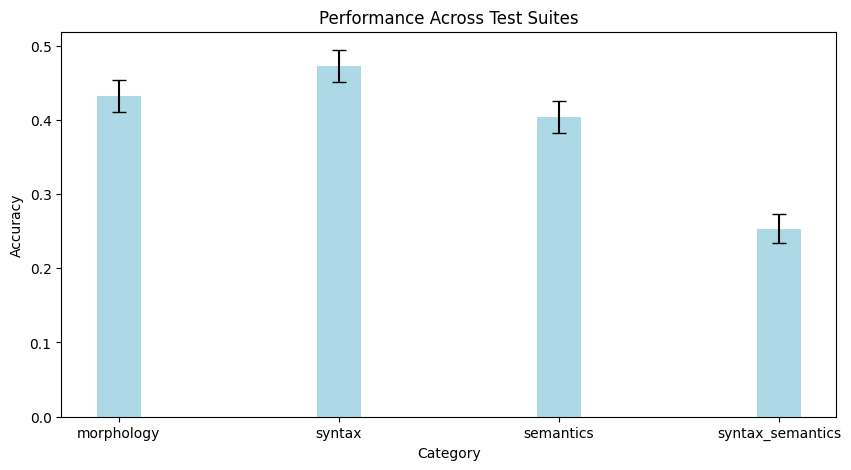

In [62]:
# calculate the performance as described above by category and plot the results in a bar plot with CIs
### YOUR CODE HERE ###

# figute size
fig = plt.figure(figsize = (10, 5))

# plot creating
plt.bar(categories_list, accuracy_values, 
        color ='lightblue', 
        width = 0.2, 
        yerr = [np.array(accuracy_values) - np.array(confidence_intervals_lower), 
                np.array(confidence_intervals_upper) - np.array(accuracy_values)],
        capsize = 5)

plt.xlabel("Category")
plt.ylabel("Accuracy")
plt.title("Performance Across Test Suites")
plt.show()

## Exercise 2: Evaluating societal biases (13 points)

In this exercise, we will consider aspects of LLM performance which may have social implications and that are deeply interconnected with how humans use language. This task evaluates whether LLMs overrepresent certain cultures over others, which could be due to, e.g., imbalances over training data sources and languages.

> Specifically, your task is to come up with an appropriate test item and evaluate whether LLMs exhibit certain cultural biases. 
> In this task, you have to construct your own multiple-choice test item for investigating cultural biases of LLMs, where, given a context, the different available response / continuation options would reflect preferences for responses typical for different cultures. 
> For instance, one response could be more acceptable under one particular cultural lense and another response under a different cultural background. 
> Your task is then to evaluate the performance of two LLMs: the mostly monolingual `gpt2` and the multilingual `bigscience/bloom-560m` model. The second part of the task is to compelte the evaluation code and interpret the results by answering the question below.


Here is a simple example of a test item. More explanations are in parentheses. You should provide analogous explanations in the answers to the questions below, but not pass these to the LLMs during evaluations.


Context 1: You are at a German supermarket. You walk up to the cashier and greet them by saying:

Context 2: You are at an American supermarket. You walk up to the cashier and greet them by saying:

A. Hello. (intuititvely, more likely in to be appropiate in the Germany context condition)

B. Bye. (a generally inappropriate response)

C. Hello, how are you? (intuitively, more likely to be appropriate in the US context condition; people usually don’t ask strangers ‘how are you’ in Germany)

I would say: (insert each of the answer options separately here and calculate their log probability, given each of the contexts).


For reference about constructing datasets and inspiration, feel free to take a look at the [ETHICS dataset](https://arxiv.org/pdf/2008.02275), e.g., Fig. 2, where the authors came up with different continuations tapping into different conditions, given a context.

> **Fill in your responses below.**
>
> 1. Your prompt (with explanations of the intuitive differences for each response option in respective cultural variations): <br>
>  **Answer**: <br>
> - Context 1: You are shopping with a German friend and just tried on new clothes. You want to know your friend's opinion on the outfit. And your friend said:
> - Context 2: You are shopping with a American friend and just tried on new clothes. You want to know your friend's opinion on the outfit. And your friend said:
> - Options
>   - A. "It looks bad, and not suitable for most daily occasions" (DE. More likely to be direct and value the practicality)
>   - B. "You look ugly". (generally inappropriate, as it’s seen as impolite)
>   - C. "Are you kidding? You look amazing!". (USA. More cheeringful and encouraging)
>
> 
> 2. Your model log probabilities (table cells are examples, please fill in with your respective item):
>
| Context / Option | GPT-2 | Bloom |
|------------------|-------|-------|
| Germany + A      | -14.465622  | -14.311432 |
| USA + A          | -15.856544  | -15.430267 |
| Germany + B          | -13.668892  | -13.339478 |
| USA + B      | -14.285263  | -13.875671 |
| Germany +c      | -11.627052  | -11.877838 |
| USA + C        |  -11.876839     |   -12.287628    |

> 3. Do the models show a preference for a particular cultural setting? Is there evidence for whether cultural biases might be caused by training data? <br>
>   **Answer**: No, no preference as the scores are pretty similar.
> 4. Are there aspects of the prompt that might influence your results? Please provide a brief justification / example why (not). <br>
>   **Answer**: As culture bias is a broad term, maybe including descriptions on cultural difference could help. For example, in each context includes information such as German people generally values practicality while USA people tend to value feelings or emotions more.

In [36]:
from minicons import scorer 
import pandas as pd

In [37]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [48]:
# set up a scorer 
gpt2_scorer = scorer.IncrementalLMScorer(
    "gpt2", device=device
)

bloom_scorer = scorer.IncrementalLMScorer(
    "bigscience/bloom-560m", device=device
)

# initialize list for storing the predictions
gpt2_predictions = []
bloom_predictions = []

answer_keys = ["ger", "nonsense", "us"]

# format / provide the possible answer options from your vignette
ger = "It looks bad, and not suitable for most daily occasions"
nonsense = "You look ugly."
us = "Are you kidding? You look amazing!"

# answer options
contexts = [
    "You are shopping with a German friend and just tried on new clothes. You want to know your friend's opinion on the outfit. And your friend said:",
    "You are shopping with an American friend and just tried on new clothes. You want to know your friend's opinion on the outfit. And your friend said:"
]

# iterate over contexts
for context in contexts:
    # pass a list of contexts and a list of continuations to be scored
    context_list = [context] * len(answer_keys)
    
    answer_scores_gpt2 = gpt2_scorer.conditional_score(
        context_list, answer_keys
    )
    gpt2_predictions.append(answer_scores_gpt2)

    # score for bloom
    answer_scores_bloom = bloom_scorer.conditional_score(
        context_list, answer_keys
    )
    bloom_predictions.append(answer_scores_bloom)  # Fixed here

# check / inspect which answer has the highest score and which answer type (i.e., "culture") it corresponds to
labels = ['Germany + A', 'Germany + B', 'Germany + C', 'USA + A', 'USA + B', 'USA + C']
gpt2_flat_predictions = [score for sublist in gpt2_predictions for score in sublist]
bloom_flat_predictions = [score for sublist in bloom_predictions for score in sublist]

# Ensure the lengths match before creating the DataFrame
if len(gpt2_flat_predictions) == len(bloom_flat_predictions) == len(labels):
    df = pd.DataFrame({
        'Context': labels,
        'GPT-2': gpt2_flat_predictions,
        'Bloom': bloom_flat_predictions
    })
    print(df)
else:
    print("Length mismatch: GPT-2 predictions, Bloom predictions, and labels must all have the same length.")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


       Context      GPT-2      Bloom
0  Germany + A -14.465622 -14.311432
1  Germany + B -13.668892 -13.339478
2  Germany + C -11.627052 -11.877838
3      USA + A -15.856544 -15.430267
4      USA + B -14.285263 -13.875671
5      USA + C -11.876839 -12.287628


## Exercise 3: LLM evaluations with LLMs (5 points)

Building on the in-context learning capabilities of LLMs,, recent work, e.g., by [Perez et al (2022)](https://arxiv.org/abs/2212.09251), has been *using LLMs to generate evaluation datasets for LLMs*. 

> Your task here is to: 
> 1. write a pseudo-algorithm for generating more cultural bias evaluation items. The items should be of a similar structure as in the task above. Write maximally 5 steps. (Hint: feel free to try to elicit e.g. 10 different item with a model of your choice)
> 2. What could be possible concerns with this approach? Name and briefly explain 2.

### My answer:
*If I understand correctly, just descibing the how-to steps?*

#### Psedo-algorithm
- Step 1: **Set up the context**: identify two distinct cultural contexts that relfects the language use.
- Step 2: **Generate options**: For each contexts, use language models to generate relevant multiple options. One appropriate response for each culture, and an inappropriate one for both.
- Step 3: **Format the test item**: Write clear prompts and options
- Step 4: **Evaluate and iterate**: Run the test items through LLMs.

#### Concerns:
- Stereotypes: The stereotypes might be reinforce unintentionally.
- Bias: If the data trained on is already biased, then there might be overfitting issue.

## Exercise 4: How human-like are Llama's surprisals? (22 points)

More recently, work more informed by human language use and processing has compared LLMs’ performance to aspects of human behavior. Here, the assessment of LLMs is guided more by the question of how human-like certain aspects of its performance are. For instance, we might whether LLMs' 'knowledge' of language is comparable to human knowledge, and, in particular, whether the processing of language, given the knowledge , can be compared via system-appropriate linking measurements.

Your task in this exercise is to assess whether the *surprisal* of different language models is comparable to human *reading times*, when it comes to processing subject-verb agreement. The linking hypothesis is that these can be considered the respective predictability, and therefore, processing load indicators.
The conceptual ideas and the data are taken from [Wilcox et al. (2021)](https://arxiv.org/pdf/2106.03232) which was discussed in the lecture. Please read the sections 1-2.2 for the background (optionally, the rest, if you want).
The data can be downloaded [here](https://github.com/CogSciPrag/Understanding-LLMs-course/tree/main/understanding-llms/homework/data/SVA_data.csv).

The data provides human RTs and LM surprisals in different conditions for sentences where the subject and the verb either match (i.e., agree) or mismatch in terms of number. This is the main condition. Furthermore, the agreement manipulation occurs in different syntactic conditions, and for plural and singular nouns. Here are examples from the different syntactic conditions:
* SRC (subject relative clause modifier):
  * mismatch plural: The pilots that injured the teacher brings love to people.
  * match plural: The pilots that injured the teacher bring love to people.
* ORC (object relative clause modifier):
  * mismatch plural: The ministers that the manager injured knows tennis.
  * match plural: The ministers that the manager injured know tennis.
* PP (prepositional phrase modifier):
  * mismatch plural: The executives next to the teacher is good.
  * match plural: The executives next to the teacher are good.

The prediction is that humans and models should have difficulty processing the mismatched noun, both in the singular and the plural condition.

> Your task is to complete / provide the following code and answer the following questions:
> 1. Formulate a quantitatively testable hypothesis operationalizing the prediction above. I.e., formulate something like: if the prediction is true, X should be larger than Y.
> 2. Provide respective examples for the singular condition.
> 3. Inspect the data. What are the units of the provided results?<br>
> **Answer** <br> Please see the output.
> 4. Based on your hypothesis above, for each trial, calculate whether it holds or not. Plot the proportion of trials where your hypothesis is borne out (i.e, the accuracy), for humans and each model, in the singular and the plural condition. (Hint: use a barplot)
> 5. Based on visual inspection, does any model match human performance? <br>
> **Answer** <br>
> Unfortunately no.
>
> 6. Is either of the number conditions more difficult to process for humans or LMs? <br>
> **Answer** <br>
> For humans: singular. For LMs: plural.
>
> 8. Select the results for Llama and humans only. Is the processing 'difficulty' of Llama correlated with the processing slowdown of humans (across singular / plural conditions)? Interpret the correlation coefficient. <br>
> **Answer** <br>
> Not it is not. The correlation coeffiency reveals a weak relationship that is not significant: The Pearson correlation coefficients are around 0.053 (p = 0.746) and 0.139 (p = 0.392), indicating a lack of significant correlation.

In [49]:
# Just make sure pkgs are installed and imported
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [53]:
df = pd.read_csv("/Users/ychen/Notes-ULLM/HW4/SVA_data.csv")
df.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/frame.py", line 1175, in _repr_html_
    else:
          
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

      suite  region_number group  model  match_plural  match_sing  mismatch_plural  mismatch_sing
0  SVNA-orc              7  1010   gpt2      7.740553    7.936675        11.336713       8.637131
1  SVNA-orc              7  1010   grnn      5.123765    4.921309         5.999019       7.279292
2  SVNA-orc              7  1010  human    633.333333  914.000000       733.000000    1012.125000
3  SVNA-orc              7  1010   jrnn      4.376238    4.826594         6.055298       6.815393
4  SVNA-orc              7  1010  llama      5.940623    5.992930        10.196010      10.679944

In [58]:
#### YOUR CODE HERE FOR CALCULATING HYPOTHESIS METRICS AND PLOTTING ####
# import numpy as np

# Extract and clean data for different models
models = ['human', 'gpt2', 'grnn', 'jrnn', 'llama', 'rnng']
dfs = {model: df[df['model'] == model].dropna() for model in models}

def calculate_accuracy(data):
    """
    Calculate accuracy.

    Parameters:
    model (pd.DataFrame): DataFrame containing columns
                          'mismatch_plural', 
                          'match_plural',
                          'mismatch_sing',
                          'match_sing'.

    Returns:
    Accuracy for plural and singular mismatches.
    """
    sg_accuracy = np.mean(data['mismatch_sing'] > data['match_sing'])
    pl_accuracy = np.mean(data['mismatch_plural'] > data['match_plural'])

    return sg_accuracy, pl_accuracy

    # Calculate accuracy for each model
accuracies = {model: calculate_accuracy(dfs[model]) for model in models}

# Prepare data for plotting
accuracy_data = {
    'Model': [],
    'Accuracy': []
}

for model in models:
    sg_acc, pl_acc = accuracies[model]
    accuracy_data['Model'].extend([f'{model.capitalize()}_Sg', f'{model.capitalize()}_Pl'])
    accuracy_data['Accuracy'].extend([sg_acc, pl_acc])

accuracy_df = pd.DataFrame(accuracy_data)

# Return the final dataframe
accuracy_df

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/frame.py", line 1175, in _repr_html_
    else:
          
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

       Model  Accuracy
0   Human_Sg     0.875
1   Human_Pl     0.575
2    Gpt2_Sg     0.775
3    Gpt2_Pl     0.925
4    Grnn_Sg     0.625
5    Grnn_Pl     0.825
6    Jrnn_Sg     0.700
7    Jrnn_Pl     0.800
8   Llama_Sg     0.850
9   Llama_Pl     0.925
10   Rnng_Sg     0.775
11   Rnng_Pl     1.000

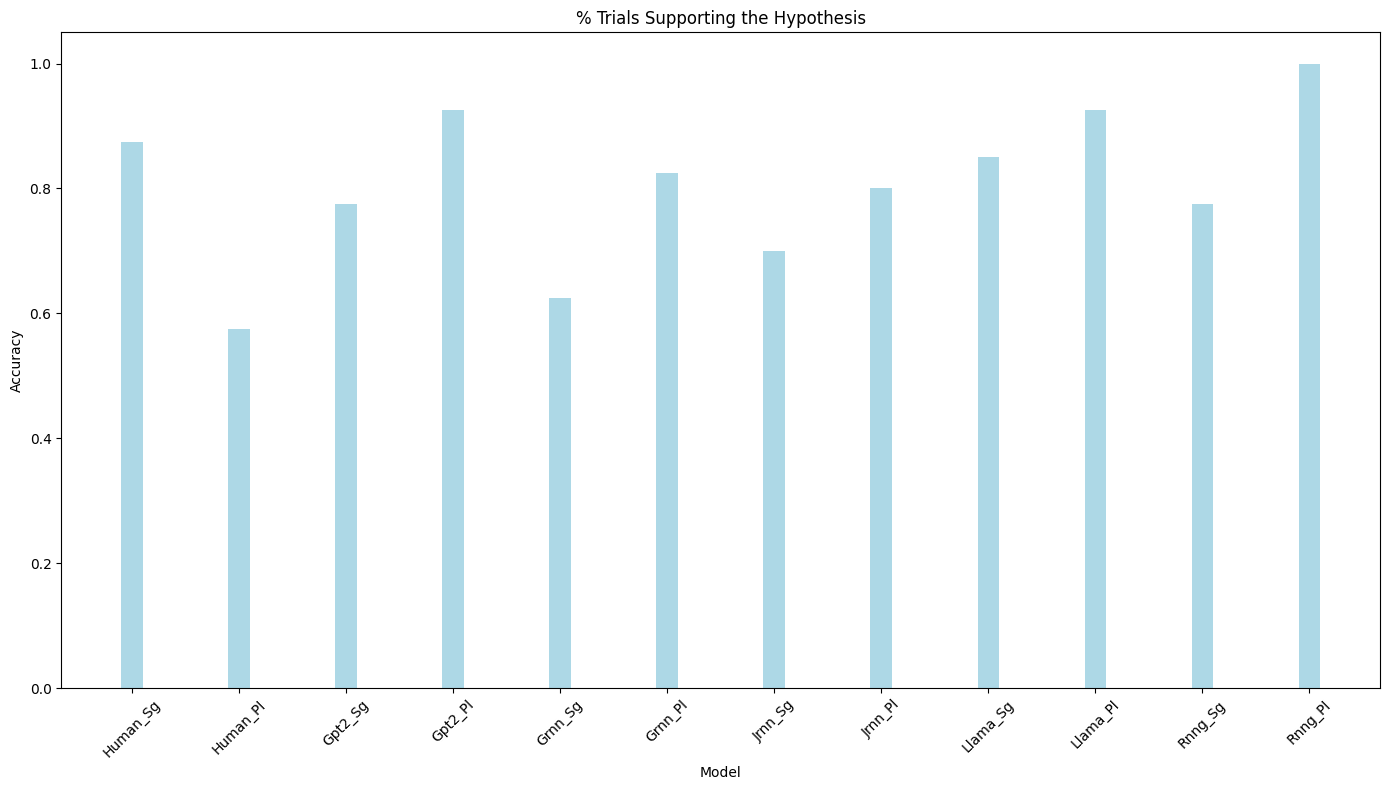

In [60]:
# barplot of the results, by model and by condition (plural vs. singular)
### YOUR CODE HERE ###
# Plot the results
plt.figure(figsize=(14, 8))
plt.bar(accuracy_data['Model'], 
        accuracy_data['Accuracy'], 
        color ='lightblue', 
        width = 0.2)
plt.title('% Trials Supporting the Hypothesis')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, fontsize=10)  # Adjust x-ticks fontsize and rotation if needed
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [61]:
# correlation analysis
#### YOUR CODE HERE ###

sg_correlation = pearsonr(human_sglist, llama_sglist)
pl_correlation = pearsonr(human_pllist, llama_pllist )

sg_correlation, pl_correlation

(PearsonRResult(statistic=0.052925612402496346, pvalue=0.7456775488245941),
 PearsonRResult(statistic=0.13920285090358003, pvalue=0.39163243168344136))